# Graphes, jeux et heuristiques

# Jeux d'accessibilité à 2 joueurs

On s'intéresse à des jeux respectant les conditions suivantes :

- deux joueurs jouent à tour de rôle, en connaissant l'ensemble de la situation (pas de *cartes cachées* par exemple);

- sans mémoire : la stratégie à adopter à un moment donné du jeu ne dépend pas de l'*histoire* passée. ;

- sans hasard.

Exemples de tels jeux : dames, échecs, go, ...

Ces jeux peuvent être modélisés par des graphes orientés finis : chaque sommet est une situation (on parle aussi de position) et chaque arête correspond à une décision, un coup possible. On peut alors voir le jeu comme le déplacement d'un jeton sur ce graphe : on démarre sur un sommet donné et à tour de rôle les joueurs déplacent le jeton en suivant des arêtes.
On s'intéressera plus particulièrement aux jeux d'*accessibilité* : pour gagner, chaque joueur a pour but d'atteindre un ou plusieurs sommets particuliers.

Dans un premier, nous allons nous intéresser à un jeux *simple* pour lequel il est possible de déterminer une stratégie gagnante, puis nous verrons, pour les jeux
les plus complexes, comment bâtir une stratégie à l'aide d'une heuristique.

## Présentation du jeux de Nim

Le jeux de Nim est devenu populaire en France à travers l'émission *Fort Boyard*, qui en présente une version :

<video controls src="vid/Batonnets_FB.mp4" width="650"><\video>

D'autres versions existent, avec d'autres règles.
    
**Question 1 :**  Compléter le code suivant pour représenter le graphe de ce jeux : chaque sommet est une situation possible (qu'on numérote selon le nombre de bâtonnets restants), et chaque arc un coup possible. On se limite ici à la fin du jeu, avec au plus 8 bâtonnets restants.

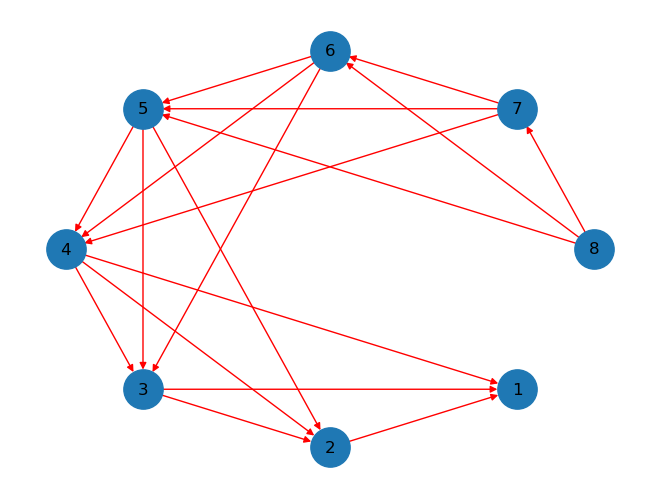

In [73]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

Dict_Nim = {'8': ('7', '6', '5'),
            '7': ('6', '5', '4'),
            '6': ('5', '4', '3'),
            '5': ('4', '3', '2'),
            '4': ('3', '2', '1'),
            '3': ('2', '1'),
            '2': ('1',)}

# Création du graphe en networkx :
Graphe_Nim = nx.DiGraph(Dict_Nim)

# Représentation graphique à l'aide de Matplotlib :
nx.draw_circular(Graphe_Nim, node_size=800, edge_color='red', with_labels=True)
plt.show()

Ce graphe est nommé *arène* . Ce jeux fait partie des jeux d'*accessibilité* car le graphe associé ne comporte pas de cycle (ce qui assure que toute partie est finie), et il est déterminé par un ensemble de positions (les cibles) qui sont sans successeurs. Ainsi,
dans le jeu de Nim, le nœud 1 du graphe associé est la seule cible du jeu, et l'atteindre signifie la fin de la partie (et la défaite pour celui qui l'atteint).

## Graphe biparti

L'inconvénient de de la représentation précédente est qu'elle ne permet pas de distinguer entre les coups réalisés par le premier joueur (J1) et ceux réalisés par le second (J2 ). Pour pallier ce problème, on ne va pas seulement représenter les positions possibles mais aussi différencier les sommets selon s'ils correspondent à un tour du premier ou du second joueur. Pour ce faire, on va en quelque sorte *dédoubler* ce graphe (sauf la position de départ qui ne peut être jouée que par le premier joueur) : on créera ainsi un **graphe biparti**.

**Question 2 :** Compléter le code suivant permettant de définir un nouveau dictionnaire d'adjacence correspondant à un graphe biparti. Pour cela, les noms des sommets seront indexés par la lettre *a* si c'est au tour du premier joueur de retirer des bâtonnets, *b* sinon.

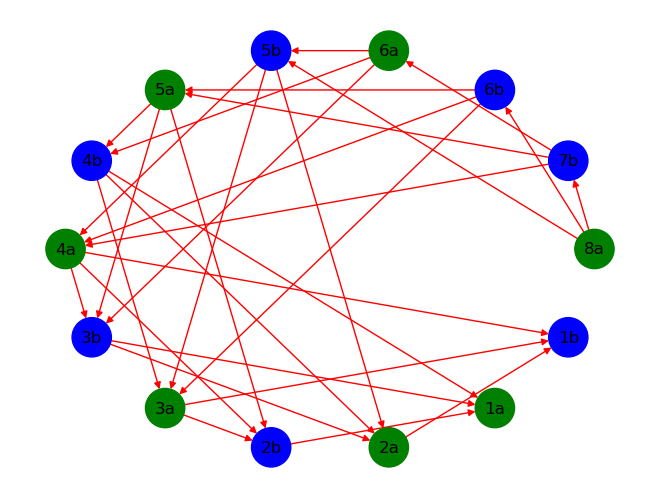

In [98]:
Dict_B_Nim = {'8a': ('7b', '6b', '5b'),
              '7b': ('6a', '5a', '4a'),
              '6b': ('5a', '4a', '3a'),
              '6a': ('5b', '4b', '3b'),
              '5b': ('4a', '3a', '2a'),
              '5a': ('4b', '3b', '2b'),
              '4b': ('3a', '2a', '1a'),
              '4a': ('3b', '2b', '1b'),
              '3b': ('2a', '1a'),
              '3a': ('2b', '1b'),
              '2b': ('1a',),
              '2a': ('1b',),
              '1a': (),
              '1b': ()}

# Création du graphe en networkx :
Graphe_B_Nim = nx.DiGraph(Dict_B_Nim)

# Représentation graphique à l'aide de Matplotlib :
color_map = []
for node in Graphe_B_Nim:
    if 'a' in node :
        color_map.append('green')
    else: 
        color_map.append('blue')      
nx.draw_circular(Graphe_B_Nim, node_color=color_map, node_size=800, edge_color='red', with_labels=True)
plt.show()

Dans ce graphe, comme dans tout graphe biparti à 2 joueurs, un arc ne peut relier qu'un sommet *a* à un sommet *b* et réciproquement. Tous ces graphes **bipartis**, comme leur nom l'indique, sont composés de *deux parties*, ici de différentes couleurs. On peut même en faire une définition : *Un graphe est biparti si et seulement si on peut colorer ses
sommets avec seulement deux couleurs sans que deux sommets voisins n'aient la même couleur.*

Un **état (ou position) final** correspond à un sommet duquel ne part aucun arc : il correspond à une fin de partie. Ces états peuvent est classé en trois catégories : les états gagnants pour le joueur 1, les états gagnants pour le jour 2, et les états de match nul.

**Question 3 :** Dans ce graphe biparti, combien existe-t-il d'états finaux ? Les classer.

Il existe 2 états finaux : le sommets 1b, état gagnant pour le joueur 1, et le sommet 1a, état gagnant pour le joueur 2. Il n'y a aucun état de match nul.

## Un autre exemple : le jeu de Chomp

On considère une version simplifiée de ce jeux dans laquelle le "plateau" est similaire à une tablette de chocolat de $n$ lignes et $m$ colonnes, et dont le carreau situé en haut à gauche (première ligne et première colonne) est empoisonné.

![image](im/Chomp1.png)   

À tour de rôle, les deux joueurs coupent la tablette suivant une verticale ou une horizontale et mange les colonnes à droite ou les lignes en dessous de cette découpe. La partie se termine lorsqu'il ne reste que le carré empoisonné et que le joueur doit donc le manger. Voici un exemple de partie :

![image](im/Chomp2.png)   


**Question 4 :** On part d'une tablette composée de 2 lignes et 3 colonnes. Quels sont les différents états possibles ? Quels sont les états finaux ? Écrire alors le code permettant de définir le dictionnaire `Dict_Chomp` du graphe biparti correspondant à ce jeux. On nommera les états (sommet du graphe) par un tuple `(i, j, Jk)` avec `i` et `i` le nombre de lignes et colonnes restantes de la tablette, et  `J1` ou `J2` le joueur.

Voici les 5 états possibles, avec l'état de départ (état 0) et l'unique état final (état 5, état doublé si on considère les deux joueurs):

![image](im/Chomp3.png)   

In [117]:
Dict_Chomp = {(2, 3, 'J1'): ((2, 2, 'J2'), (2, 1, 'J2'), (1, 3, 'J2')),
              (2, 2, 'J2'): ((2, 1, 'J1'), (1, 2, 'J1')),
              (1, 3, 'J2'): ((1, 2, 'J1'), (1, 1, 'J1')),
              (2, 1, 'J2'): ((1, 1, 'J1'),),
              (2, 1, 'J1'): ((1, 1, 'J2'),),
              (1, 2, 'J1'): ((1, 1, 'J2'),),
              (1, 1, 'J2'): (),
              (1, 1, 'J1'): ()}

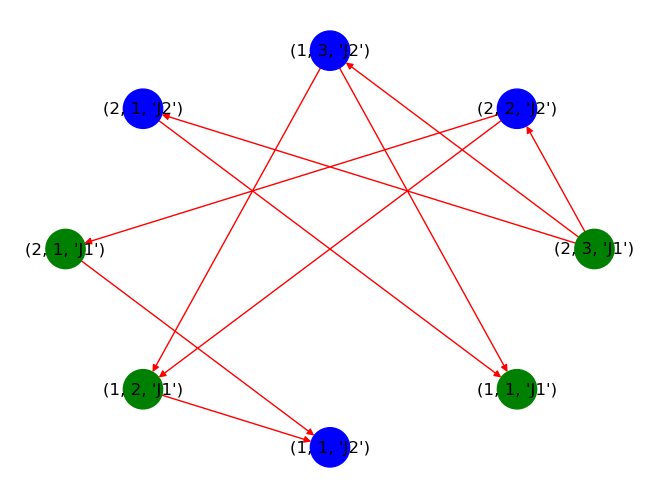

In [118]:
# Création du graphe en networkx :
Graphe_Chomp = nx.DiGraph(Dict_Chomp)

# Représentation graphique à l'aide de Matplotlib :
color_map = []
for node in Graphe_Chomp:
    if 'J1' == node[2] :
        color_map.append('green')
    else: 
        color_map.append('blue')       
nx.draw_circular(Graphe_Chomp, node_color = color_map, node_size=800, edge_color='red', with_labels=True)
plt.show()

## Parcours et graphe biparti

On rappelle l'algorithme de parcours en largeur d'un graphe :

In [65]:
def creer_file():
    return deque()
   
def defiler(F):
    """ Enlève la fin de la file F, soit son dernier élément, celui tout à droite """
    if len(F)==0:
        raise ValueError("Erreur : file vide")
    else :
        F.pop()
    return(F)

def enfiler(F,v):
    """ Ajoute l'élément v au début de la file F, v devient le premier élément, celui tout à gauche """
    F.appendleft(v)

def est_vide(F):
    return len(F)==0

def fin(F):
    """ Retourne la fin de la file F, soit son dernier élément, celui tout à droite """
    if est_vide(F)==1:
        raise ValueError("Erreur : file vide")
    else :
        return F[-1]

def BFS(Graphe, sommet_dep):
    """ Retourne la liste des sommets du graphe Graphe parcouru lors d'un parcours en largeur, en partant du sommet sommet_dep"""
    
    Visités = [] # Liste des sommets déjà visités
    
    A_visiter = creer_file() # File des sommets à visiter
    enfiler(A_visiter, sommet_dep)
    
    while est_vide(A_visiter) == False :    
        
        # On considère un sommet de la pile encore non visité :
        if fin(A_visiter) in Visités :
            defiler(A_visiter)
        else :
            sommet_vis = fin(A_visiter)

            # On indique qu'on l'a visité :
            defiler(A_visiter)
            Visités.append(sommet_vis)

            # On met à jour la pile des sommets à visiter, à partir des voisins :
            for sommet_adj in Graphe[sommet_vis] :
                if sommet_adj not in Visités :
                    enfiler(A_visiter, sommet_adj)

    return Visités

**Question 5 :** Adapter ou utiliser la fonction précédente pour écrire une fonction `est_biparti` qui prend en argument un graphe (sous forme d'un dictionnaire d'adjacence) et un sommet de départ, et retourne un booléen (`True` si le graphe est bien biparti, `False` sinon).

In [106]:
def est_biparti(Graphe, sommet_dep):
    
    Couleur = (0, 1)
    
    k = 0
    
    Dict_coul = dict()
    
    Visités = [] # Liste des sommets déjà visités
    
    A_visiter = creer_file() # File des sommets à visiter
    enfiler(A_visiter, sommet_dep)
    Dict_coul[sommet_dep] = Couleur[k]
    
    while est_vide(A_visiter) == False :    
        
        # On considère un sommet de la pile encore non visité :
        if fin(A_visiter) in Visités :
            defiler(A_visiter)
        else :
            sommet_vis = fin(A_visiter)
            # On indique qu'on l'a visité :
            defiler(A_visiter)
            Visités.append(sommet_vis)
            
            # Couleur du sommet : 
            k = Dict_coul[sommet_vis]

            # On change la couleur pour les voisins :
            k += 1
            k %= 2
            # On met à jour la pile des sommets à visiter, à partir des voisins :
            for sommet_adj in Graphe[sommet_vis] :
                
                if sommet_adj not in Dict_coul :
                    Dict_coul[sommet_adj] = Couleur[k]
                else :
                    if Dict_coul[sommet_adj] != Couleur[k]:
                        return False
                if sommet_adj not in Visités :
                    enfiler(A_visiter, sommet_adj)
    # Pour vérification :
    print(Dict_coul)                        
    return True

Autre version, en utilisant le BFS complet :

In [107]:
def est_biparti_bis(Graphe, sommet_dep):
    Visités = BFS(Graphe, sommet_dep)
    Couleur = (0, 1)
    
    k = 0
    
    Dict_coul = dict()
    
    Dict_coul[sommet_dep] = Couleur[k]
    
    for sommet in Visités :
        k = Dict_coul[sommet]
        k += 1
        k %= 2
        for sommet_adj in Graphe[sommet] :
            if sommet_adj not in Dict_coul :
                Dict_coul[sommet_adj] = Couleur[k]
            else :
                if Dict_coul[sommet_adj] != Couleur[k]:
                    return False
    return True         

*Remarque : ces algorithmes peuvent reposer  peut utiliser n'importe quelle fonction méthode parcours, pas seulement le BFS*.

In [102]:
est_biparti(Dict_B_Nim, '8a')

{'8a': 0, '7b': 1, '6b': 1, '5b': 1, '6a': 0, '5a': 0, '4a': 0, '3a': 0, '2a': 0, '4b': 1, '3b': 1, '2b': 1, '1b': 1, '1a': 0}


True

In [105]:
est_biparti_bis(Dict_B_Nim, '8a')

True

In [119]:
est_biparti(Dict_Chomp,((2,3,'J1')))

{(2, 3, 'J1'): 0, (2, 2, 'J2'): 1, (2, 1, 'J2'): 1, (1, 3, 'J2'): 1, (2, 1, 'J1'): 0, (1, 2, 'J1'): 0, (1, 1, 'J1'): 0, (1, 1, 'J2'): 1}


True

In [114]:
Dict_Chomp[ (2,3,'J1')]

((2, 2, 'J2'), (2, 1, 'J2'), (1, 3, 'J2'))

Essayons avec un autre graphe, non biparti :

In [110]:
Dict_NB = {'8a': ('7b', '6b', '5b'),
           '7b': ('6a', '5a', '4a'),
           '6b': ('5a', '4a', '3a'),
           '6a': ('5b', '4b', '3b', '2a'),
           '5b': ('4a', '3a', '2a'),
           '5a': ('4b', '3b', '2b'),
           '4b': ('3a', '2a', '1a'),
           '4a': ('3b', '2b', '1b'),
           '3b': ('2a', '1a'),
           '3a': ('2b', '1b'),
           '2b': ('1a',),
           '2a': ('1b',),
           '1a': (),
           '1b': ()}

print(est_biparti(Dict_NB, '8a'), est_biparti_bis(Dict_NB, '8a'))

False False


## Stratégie et positions gagnantes

Afin de gagner presque *à coup sur* les joueurs auront intérêt à définir une *méthode* pour déterminer quels coups jouer au fur et à mesure de la partie : c'est l'idée d'une **stratégie**. Une telle **stratégie** détermine de façon univoque et répétable le mouvement suivant à jouer, à partir d'un état ou position.

Une **stratégie** est dite **gagnante** pour un joueur si toute partie jouée en suivant cette stratégie est gagnante, à partir d'une position de départ donnée.

Une **position** est dite **gagnante** s'il existe une stratégie gagnante à partir de cette position.

**Question 6 :** Pour le jeu de Nim, déterminer les positions gagnantes pour le joueur 1. En déduire une stratégie gagnante à partir du sommet 8a. En généralisant pour $n$ bâtonnets, donner une indication sur des positions perdantes.

Pour le joueur 1, l'état final 1b est gagnant, et il a pour antécédents 2a, 3a et 4a : ce sont donc aussi des positions gagnantes pour lui. Comme 5b n'est relié qu'à ces trois états, c'est aussi une position gagnante pour le joueur 1. Or le joueur 1 peut atteindre directement 5b à partir de 8a : 8a est donc une position gagnante, et il existe une stratégie gagnante consistant à choisir de passer par 5b puis d'agir "intelligemment".

En itérant ce raisonnement, on peut montrer que les positions avec $4n + 1$ bâtonnets ($n \in N$) sont perdantes pour le joueur qui doit jouer. Ainsi si le nombre de  bâtonnets au départ est de la forme $4n$, $4n + 2$ ou $4n + 3$, alors le joueur 1 possède une stratégie gagnante; s'il est de la forme $4n + 1$ alors c'est le joueur 2 qui aura une stratégie gagnante. En particulier, à Fort Boyard, la partie débute avec 20 bâtonnets et 20 = 4 × 5 donc le joueur qui commence devrait toujours gagner !

# Notion d'heuristique

## Complément sur la théorie des jeux : arbre de décision et heuristique

La détermination de stratégies gagnantes repose souvent sur la détermination de positions gagnantes, en partante de l'état final gagnant; Mais cette méthode se heurte généralement à la complexité des jeux :

- pour le jeu du morpion, il y a $765$ positions possibles,

- pour le jeu du puissance 4, il y a environ $4,5\times10^{12}$ positions possibles

- pour les échecs, il y a de l'ordre de $10^{120}$ parties possibles

- enfin pour le jeu de go, il y a de l'ordre de $10^{170}$ positions possibles, ce qui donne approximativement $10^{600}$ parties possibles.

Les parties possibles peuvent être représentées par des **arbres de décision**; comme celui ci-dessous, pour l'exemple du jeu de Nim avec 6 bâtonnets au départ :

![image](im/Arbre.png)   

Chaque sommet est une position du jeu (ici sous forme de cercle ou carré selon le joueur dont c'est le tour), et les arrêtes les coups possibles. Le déroulement de la partie se lit de haut en bas. Les positions finales, les plus "basses", sont nommées *feuilles* de l'arbre, et leur nombre représente le nombre de parties possibles. 

Sur un jeu complexe, plutôt que de chercher une stratégie gagnante (car parcours de l'arbre entier impossible), on peut proposer une **heuristique** : il s'agit d'évaluer quelles sont les positions les plus *avantageuses* pour le joueur considéré, à l'aide du fonction *simple*, afin de faire un *bon choix*. Il ne s'agit pas forcément du *meilleur* choix, car on ne parcourt pas toutes les parties pour le prouver ! 

Généralement, une **heuristique**  affecte à chaque position une valeur numérique, d'autant plus grande que cette position est estimée meilleur pour le joueur considéré. Par exemple, pour les échec, une heuristique simple attribue à chaque position un nombre entier, somme de la "valeur estimée" des pièces sur un échiquier. Classiquement 1 pour un pion, 3 pour un cavalier ou un fou, 5 pour une tour et 8 pour une dame. Cependant ce n'est pas suffisant en pratique, il faut ajouter des considérations d'occupation de l'espace, de contrôle de cases, etc. La création d'une heuristique de qualité est une tâche difficile). Pour le puissance 4, une heuristique simple consiste à attribuer à chaque case une valeur, par exemple le nombre d'alignements
potentiels de quatre pions lorsqu'on place un pion à cet emplacement (visible sur la figure ci-dessous), puis à sommer les cases occupées.

![image](im/P4.png)   

De nombreux algorithme on alors été développés pour faire la meilleure décision possible à partir de ces heuristiques. 

## Exemple d'heuristique : problème du sac à dos

Le problème du sac à dos est un problème classique d'optimisation avec contrainte. Voici son énoncé : *On dispose d'un sac pouvant supporter un poids maximal donné et de divers objets ayant chacun une valeur et un poids. Il s'agit de choisir les objets à emporter dans le sac afin d'obtenir la valeur totale la plus grande tout en respectant la contrainte du poids maximal*.

Ce problème peut se résoudre par force brute, c'est-à-dire en testant tous les cas possibles. Mais ce type de résolution présente un
problème d'efficacité. Son coût en fonction du nombre d'objets disponibles croît de manière exponentielle.
Nous pouvons envisager une stratégie gloutonne. Le principe d'un algorithme glouton est de faire le meilleur choix pour prendre
le premier objet, puis le meilleur choix pour prendre le deuxième, et ainsi de suite. Que faut-il entendre par meilleur choix ? Est-ce
prendre l'objet qui a la plus grande valeur, l'objet qui a le plus petit poids, l'objet qui a le rapport valeur/poids le plus grand ? Cela
reste à définir;

Un algorithme glouton va, **à chaque étape**, donner une solution optimale. Par exemple, pour le problème du sac-à-dos, il va proposer, à chaque étape, de mettre dans le sac-à-dos l'objet de plus grande valeur encore disponible ne faisant pas dépasser le poids maximal. C'est effectivement la meilleure solution, mais uniquement si on s'arrêtait là ! Un algorithme glouton n'assure donc pas une convergence vers un optimum global, soit vers la *meilleure solution du problème* : il s'agit d'une **heuristique**.

Pour traiter ce problème du sac-à-dos, voir l'énoncé CCINP TSI 2021 (ou le sujet 0).